In [ ]:
import warnings
from google.colab import drive
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
abspath='/content/drive/MyDrive/capstone-netflix/'

In [ ]:
#%% [code]
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pycountry_convert
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy
from wordcloud import WordCloud
import itertools
import operator


     |████████████████████████████████| 10.1MB 411kB/s 
     |████████████████████████████████| 245kB 39.4MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=f06e841f5e496522d1fea0a4f9c33a5cd5863bfe3a60c43e5038295f86e5050b
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.5 which is incompatible.
ERROR: pytest-cov 2.11.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
ERROR: pytest-mock 3.6.0 has requirement pytest>=5.0, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1

In [ ]:
ntf = pd.read_csv(abspath+'netflix_titles.csv')
ntf.rename(columns={'release_year':'year'},inplace=True)
ntf.head()

,show_id,type,title,director,cast,country,date_added,year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
IMDb_movie = pd.read_csv(abspath+'IMDb movies.csv')
IMDb_movie.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [ ]:
IMDb_names = pd.read_csv(abspath+'IMDb names.csv')
IMDb_names.head()

,imdb_name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,place_of_death,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children
0,nm0000001,Fred Astaire,Frederic Austerlitz Jr.,177.0,"Fred Astaire was born in Omaha, Nebraska, to J...","May 10, 1899 in Omaha, Nebraska, USA",1899-05-10,"Omaha, Nebraska, USA","June 22, 1987 in Los Angeles, California, USA ...",1987-06-22,"Los Angeles, California, USA",pneumonia,Robyn Smith (27 June 1980 - 22 June 1987) (hi...,2,0,1,2
1,nm0000002,Lauren Bacall,Betty Joan Perske,174.0,Lauren Bacall was born Betty Joan Perske on Se...,"September 16, 1924 in The Bronx, New York City...",1924-09-16,"The Bronx, New York City, New York, USA","August 12, 2014 in New York City, New York, US...",2014-08-12,"New York City, New York, USA",stroke,Jason Robards (4 July 1961 - 10 September 196...,2,1,2,3
2,nm0000003,Brigitte Bardot,Brigitte Bardot,166.0,"Brigitte Bardot was born on September 28, 1934...","September 28, 1934 in Paris, France",1934-09-28,"Paris, France",NaN,NaN,NaN,NaN,Bernard d'Ormale (16 August 1992 - present)\n...,4,3,1,1
3,nm0000004,John Belushi,John Adam Belushi,170.0,"John Belushi was born in Chicago, Illinois, US...","January 24, 1949 in Chicago, Illinois, USA",1949-01-24,"Chicago, Illinois, USA","March 5, 1982 in Hollywood, Los Angeles, Calif...",1982-03-05,"Hollywood, Los Angeles, California, USA",acute cocaine and heroin intoxication,Judith Belushi-Pisano (31 December 1976 - 5 M...,1,0,0,0
4,nm0000005,Ingmar Bergman,Ernst Ingmar Bergman,179.0,"Ernst Ingmar Bergman was born July 14, 1918, t...","July 14, 1918 in Uppsala, Uppsala län, Sweden",1918-07-14,"Uppsala, Uppsala län, Sweden","July 30, 2007 in Fårö, Gotlands län, Sweden (...",2007-07-30,"Fårö, Gotlands län, Sweden",natural causes,Ingrid Bergman (11 November 1971 - 20 May 199...,5,4,5,8


In [ ]:
IMDb_ratings = pd.read_csv(abspath+'IMDb ratings.csv')
IMDb_ratings.head()

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,votes_5,votes_4,votes_3,votes_2,votes_1,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,28,9,1,5,14,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,103,28,20,13,16,6.0,1.0,6.1,114.0,6.0,239.0,6.3,115.0,6.1,425.0,6.0,1.0,6.2,102.0,6.0,210.0,6.2,100.0,6.2,50.0,NaN,NaN,5.9,12.0,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,32,16,5,6,4,NaN,NaN,5.5,25.0,5.8,72.0,6.2,62.0,5.9,146.0,NaN,NaN,5.5,21.0,5.9,67.0,6.2,55.0,5.7,15.0,NaN,NaN,5.8,4.0,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,117,63,26,25,16,NaN,NaN,5.3,23.0,5.0,111.0,5.3,193.0,5.1,299.0,NaN,NaN,5.2,20.0,4.9,96.0,5.2,171.0,5.9,39.0,NaN,NaN,5.7,3.0,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,169,66,39,20,87,7.5,4.0,7.0,402.0,7.0,895.0,7.1,482.0,7.0,1607.0,8.0,2.0,7.0,346.0,7.0,804.0,7.0,396.0,7.2,215.0,7.0,2.0,7.0,52.0,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [ ]:
IMDb_titles = pd.read_csv(abspath+'IMDb title_principals.csv')
IMDb_titles.head()

,imdb_title_id,ordering,imdb_name_id,category,job,characters
0,tt0000009,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]"
1,tt0000009,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]"
2,tt0000009,3,nm1309758,actor,NaN,"[""Chauncey Depew - the Director of the New Yor..."
3,tt0000009,4,nm0085156,director,NaN,NaN
4,tt0000574,1,nm0846887,actress,NaN,"[""Kate Kelly""]"


In [ ]:
IMDb = pd.merge(IMDb_movie,IMDb_ratings,on ='imdb_title_id')
IMDb = pd.merge(IMDb,IMDb_titles,on ='imdb_title_id')
IMDb = pd.merge(IMDb,IMDb_names,on ='imdb_name_id')

In [ ]:
IMDb.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,votes_5,votes_4,votes_3,votes_2,votes_1,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,...,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes,ordering,imdb_name_id,category,job,characters,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,place_of_death,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,5.9,154,5.9,6.0,12,4,10,43,28,28,9,1,5,14,7.2,4.0,6.0,38.0,...,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Blanche Bayliss,Blanche Bayliss,NaN,"Blanche Bayliss was born on July 10, 1878 in L...","July 10, 1878 in Lexington, Missouri, USA",1878-07-10,"Lexington, Missouri, USA","August 19, 1951 in Forest Hills, New York, USA",1951-08-19,"Forest Hills, New York, USA",NaN,NaN,0,0,0,0
1,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,5.9,154,5.9,6.0,12,4,10,43,28,28,9,1,5,14,7.2,4.0,6.0,38.0,...,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]",William Courtenay,William Hancock Kelly,NaN,"William Courtenay was born on June 19, 1875 in...","June 19, 1875 in Worcester, Massachusetts, USA",1875-06-19,"Worcester, Massachusetts, USA","April 20, 1933 in Rye, New York, USA (severe ...",1933-04-20,"Rye, New York, USA",severe cold and heart weakness,Virginia Harned (1913 - 20 April 1933) (his d...,1,0,0,0
2,tt0020403,Rivista delle nazioni,Show of Shows,1929,1929-12-29,Musical,128,USA,English,John G. Adolfi,"J. Keirn Brennan, Frank Fay",Warner Bros.,"Frank Fay, William Courtenay, H.B. Warner, Hob...",It's 1929. The studio gave the cinema its voic...,5.8,367,$ 850000,NaN,NaN,NaN,27.0,3.0,5.8,367,6.4,6.0,49,18,46,53,75,57,33,17,12,7,6.0,1.0,5.8,17.0,...,47.0,5.7,168.0,6.0,48.0,NaN,NaN,5.8,7.0,7.2,11.0,5.7,29.0,5.7,71.0,5.8,198.0,5.8,71.0,2,nm0183823,actor,NaN,"[""The Minister - Guillotine Sequence""]",William Courtenay,William Hancock Kelly,NaN,"William Courtenay was born on June 19, 1875 in...","June 19, 1875 in Worcester, Massachusetts, USA",1875-06-19,"Worcester, Massachusetts, USA","April 20, 1933 in Rye, New York, USA (severe ...",1933-04-20,"Rye, New York, USA",severe cold and heart weakness,Virginia Harned (1913 - 20 April 1933) (his d...,1,0,0,0
3,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,5.9,154,5.9,6.0,12,4,10,43,28,28,9,1,5,14,7.2,4.0,6.0,38.0,...,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0,3,nm1309758,actor,NaN,"[""Chauncey Depew -

In [ ]:
# IMDb[IMDb['imdb_title_id']=='tt0000009']

In [ ]:
# IMDb.columns

In [ ]:
IMDb_gender_age = pd.concat([IMDb.loc[:,'weighted_average_vote'],IMDb.loc[:, 'allgenders_0age_avg_vote':'females_45age_votes']],axis=1)
IMDb_gender_age = pd.concat([IMDb.loc[:,['title','year']],IMDb_gender_age],axis=1)
IMDb_gender_age.head()

,title,year,weighted_average_vote,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes
0,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0
1,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0
2,Rivista delle nazioni,1929,5.8,6.0,1.0,5.8,17.0,6.7,59.0,5.7,201.0,5.8,232.0,6.0,1.0,5.8,10.0,6.5,47.0,5.7,168.0,6.0,48.0,NaN,NaN,5.8,7.0,7.2,11.0,5.7,29.0
3,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0
4,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0


In [ ]:
IMDb_gender_age.describe()

,weighted_average_vote,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes
count,835493.000000,327553.000000,327553.000000,828616.000000,828616.000000,835434.000000,835434.000000,834768.000000,834768.000000,835485.000000,8.354850e+05,269659.000000,269659.000000,821232.000000,821232.000000,835416.000000,835416.00000,834575.000000,834575.000000,834750.000000,834750.000000,217926.000000,217926.000000,772554.000000,772554.000000,826644.000000,826644.000000,809086.000000,809086.000000
mean,5.907716,6.196160,15.304393,6.019338,1819.327720,5.871348,4144.158671,5.693316,1286.968309,5.827962,6.162485e+03,6.219476,12.575401,5.953260,1373.851594,5.826354,3398.30968,5.645531,1072.976709,6.049516,1398.056158,6.149563,4.884663,6.327366,455.317599,6.077412,701.008141,6.034692,200.061649
std,1.224279,1.838747,74.598284,1.428137,11944.201842,1.268496,22352.361379,1.237463,5424.832986,1.236726,3.405149e+04,1.759762,57.072742,1.452571,9231.686661,1.278504,18567.62381,1.251083,4524.450958,1.332579,7767.485957,1.872234,16.096055,1.725235,2864.806283,1.441828,3777.391752,1.526801,852.477006
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.200000,5.000000,1.000000,5.300000,13.000000,5.200000,70.000000,5.000000,54.000000,5.100000,1.340000e+02,5.000000,1.000000,5.200000,9.000000,5.100000,57.00000,5.000000,46.000000,5.400000,22.000000,5.000000,1.000000,5.500000,4.000000,5.300000,10.000000,5.200000,6.000000
50%,6.100000,6.000000,2.000000,6.200000,43.000000,6.100000,176.000000,5.900000,126.000000,6.000000,3.150000e+02,6.000000,1.000000,6.200000,31.000000,6.000000,143.00000,5.900000,107.000000,6.300000,59.000000,6.000000,1.000000,6.500000,11.000000,6.300000,27.000000,6.200000,17.000000
75%,6.800000,7.200000,5.000000,7.000000,202.000000,6.800000,702.000000,6.600000,438.000000,6.700000,1.180000e+03,7.200000,4.000000,7.000000,150.000000,6.700000,573.00000,6.500000,369.000000,7.000000,234.000000,7.100000,3.000000,7.400000,49.000000,7.000000,113.000000,7.000000,64.000000
max,9.900000,10.000000,2761.000000,10.000000,522182.000000,10.000000,879620.000000,10.000000,204278.000000,10.000000,1.409165e+06,10.000000,1872.000000,10.000000,422587.000000,10.000000,743676.00000,10.000000,165852.000000,10.000000,278964.000000,10.000000,630.000000,10.000000,107833.000000,10.000000,129249.000000,10.000000,34317.000000


IMDB weighted average:

w = v*R/(v+m) + m*C/(v+m)

where

v = number of votes on the movie

m = minimum number of votes to be in the top 50 (currently 1000 votes)

R = average/mean rating for the movie

C = mean rating across whole dataset

In [ ]:
def IMDB_WA(num, average, r):
  if r[num] != 0.0:
    results = ((r[num]/(r[num]+1000))*r[average]) + ((1000/(r[num]+1000))*5.9)
  else:
    results = 0.0
  return results

In [ ]:
wa_allgenders_0age = []
wa_allgenders_18age = []
wa_allgenders_30age = []
wa_allgenders_45age = []
wa_males_allages = []
wa_males_0age = []
wa_males_18age = []
wa_males_30age = []
wa_males_45age = []
wa_females_allages = []
wa_females_0age = []
wa_females_18age = []
wa_females_30age = []
wa_females_45age = []

In [ ]:
for i in range(IMDb.shape[0]):
    wa_allgenders_0age.append(IMDB_WA('allgenders_0age_votes', 'allgenders_0age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_allgenders_18age.append(IMDB_WA('allgenders_18age_votes', 'allgenders_18age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_allgenders_30age.append(IMDB_WA('allgenders_30age_votes', 'allgenders_30age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_allgenders_45age.append(IMDB_WA('allgenders_45age_votes', 'allgenders_45age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_males_allages.append(IMDB_WA('males_allages_votes', 'males_allages_avg_vote', IMDb_gender_age.iloc[i]))
    wa_males_0age.append(IMDB_WA('males_0age_votes', 'males_0age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_males_18age.append(IMDB_WA('males_18age_votes', 'males_18age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_males_30age.append(IMDB_WA('males_30age_votes', 'males_30age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_males_45age.append(IMDB_WA('males_45age_votes', 'males_45age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_females_allages.append(IMDB_WA('females_allages_votes', 'females_allages_avg_vote', IMDb_gender_age.iloc[i]))
    wa_females_0age.append(IMDB_WA('females_0age_votes', 'females_0age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_females_18age.append(IMDB_WA('females_18age_votes', 'females_18age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_females_30age.append(IMDB_WA('females_30age_votes', 'females_30age_avg_vote', IMDb_gender_age.iloc[i]))
    wa_females_45age.append(IMDB_WA('females_45age_votes', 'females_45age_avg_vote', IMDb_gender_age.iloc[i]))

In [ ]:
IMDb_gender_age['weighted_allgenders_0age'] = wa_allgenders_0age
IMDb_gender_age['weighted_allgenders_18age'] = wa_allgenders_18age
IMDb_gender_age['weighted_allgenders_30age'] = wa_allgenders_30age
IMDb_gender_age['weighted_allgenders_45age'] = wa_allgenders_45age
IMDb_gender_age['weighted_males_allages'] = wa_males_allages
IMDb_gender_age['weighted_males_0age'] = wa_males_0age
IMDb_gender_age['weighted_males_18age'] = wa_males_18age
IMDb_gender_age['weighted_males_30age'] = wa_males_30age
IMDb_gender_age['weighted_males_45age'] = wa_males_45age
IMDb_gender_age['weighted_females_allages'] = wa_females_allages
IMDb_gender_age['weighted_females_0age'] = wa_females_0age
IMDb_gender_age['weighted_females_18age'] = wa_females_18age
IMDb_gender_age['weighted_females_30age'] = wa_females_30age
IMDb_gender_age['weighted_females_45age'] = wa_females_45age

In [ ]:
IMDb_gender_age.head()

,title,year,weighted_average_vote,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,weighted_allgenders_0age,weighted_allgenders_18age,weighted_allgenders_30age,weighted_allgenders_45age,weighted_males_allages,weighted_males_0age,weighted_males_18age,weighted_males_30age,weighted_males_45age,weighted_females_allages,weighted_females_0age,weighted_females_18age,weighted_females_30age,weighted_females_45age
0,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.905179,5.903661,5.890476,5.923671,5.926527,5.901099,5.90000,5.889575,5.924054,5.903382,5.904187,5.900000,5.897433,5.894422
1,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.905179,5.903661,5.890476,5.923671,5.926527,5.901099,5.90000,5.889575,5.924054,5.903382,5.904187,5.900000,5.897433,5.894422
2,Rivista delle nazioni,1929,5.8,6.0,1.0,5.8,17.0,6.7,59.0,5.7,201.0,5.8,232.0,6.0,1.0,5.8,10.0,6.5,47.0,5.7,168.0,6.0,48.0,NaN,NaN,5.8,7.0,7.2,11.0,5.7,29.0,5.900100,5.898328,5.944570,5.866528,5.881169,5.900100,5.89901,5.926934,5.871233,5.904580,NaN,5.899305,5.914144,5.894363
3,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.905179,5.903661,5.890476,5.923671,5.926527,5.901099,5.90000,5.889575,5.924054,5.903382,5.904187,5.900000,5.897433,5.894422
4,Miss Jerry,1894,5.9,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.905179,5.903661,5.890476,5.923671,5.926527,5.901099,5.90000,5.889575,5.924054,5.903382,5.904187,5.900000,5.897433,5.894422


In [ ]:
ntf.head()

,show_id,type,title,director,cast,country,date_added,year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


Select Top10 Movie by gender and age group

In [ ]:
## netflix+IMDb
ntf_IMDb = ntf.merge(IMDb_gender_age,how='inner',on=['title','year'])

In [ ]:
ntf_IMDb.head()

,show_id,type,title,director,cast,country,date_added,year,rating,duration,listed_in,description,weighted_average_vote,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,weighted_allgenders_0age,weighted_allgenders_18age,weighted_allgenders_30age,weighted_allgenders_45age,weighted_males_allages,weighted_males_0age,weighted_males_18age,weighted_males_30age,weighted_males_45age,weighted_females_allages,weighted_females_0age,weighted_females_18age,weighted_females_30age,weighted_females_45age
0,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035
3,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035
4,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035


In [ ]:
a = ntf_IMDb.loc[:,['title','weighted_average_vote']]
b = a.drop_duplicates().reset_index(drop=True)
b = b.sort_values('weighted_average_vote',ascending= False)
c = b.head(15).reset_index(drop=True)
b['weighted_average_vote'][c.index[-1]]

6.3

In [ ]:
def Top_Gender_Age(Group, number, Age):
  df = ntf_IMDb.loc[:,['title',Group]]
  df = df.iloc[df['title'].drop_duplicates().index].reset_index(drop=True)
  df = df.sort_values(Group, ascending = False)
  df_top = df.head(number).reset_index(drop=True)
  sns.set(rc={'figure.figsize':(12,10)})
  ax = sns.barplot(x=df_top[Group],y=df_top['title'], data=df_top, palette=("crest_d"))
  ax.set(xlabel='Rating', ylabel='Movie Title')
  ax.set_title('Best Rated Movie among Users Aged {}'.format(Age), size= 20)
  for index in range(df_top.index[-1]+1):
    ax.text(df_top[Group][index], index, round(df_top[Group][index],1), color = 'black')
  return

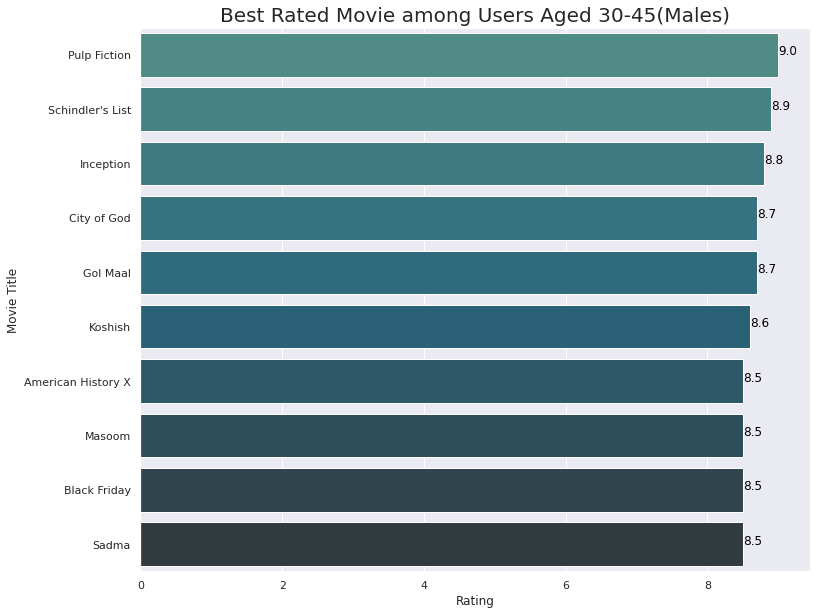

In [ ]:
Top_Gender_Age('males_30age_avg_vote',10,'30-45(Males)')

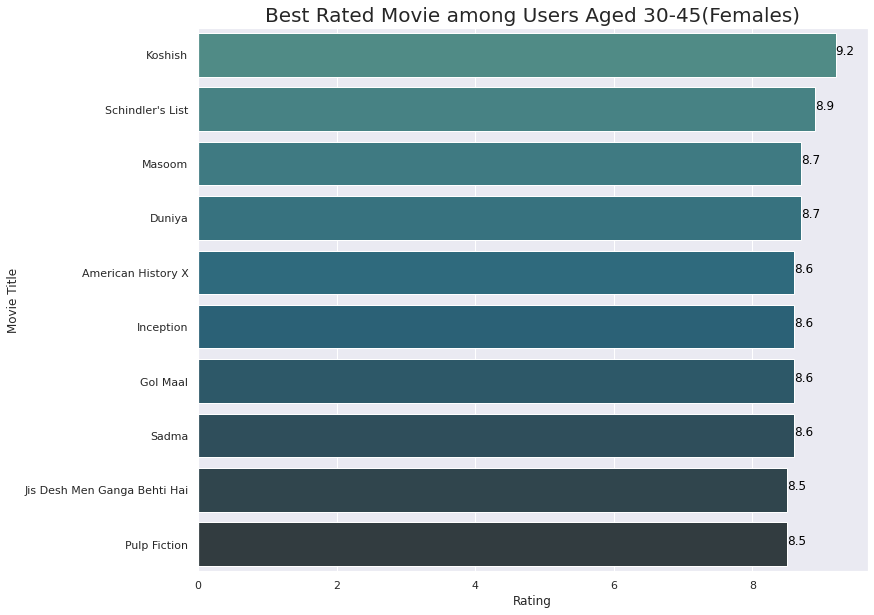

In [ ]:
Top_Gender_Age('females_30age_avg_vote', 10,'30-45(Females)')

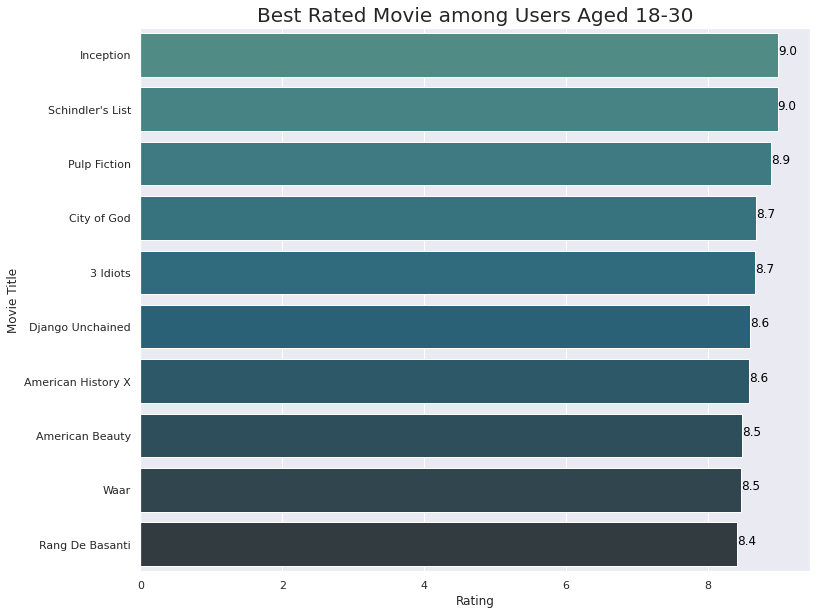

In [ ]:
Top_Gender_Age('weighted_allgenders_18age',10,'18-30')

Top Movies by Genre

In [ ]:
def Top_Genre(Genre, number):
  df = ntf_IMDb.loc[:,['title','weighted_average_vote','listed_in']]
  df = df.iloc[df['title'].drop_duplicates().index].reset_index(drop=True)
  df = df.sort_values('weighted_average_vote', ascending = False)
  index = []
  for i in range(df.shape[0]):
    if Genre in df['listed_in'][i]:
      index.append(i)
  Genre_top = df.iloc[index].reset_index(drop=True)
  Genre_top = Genre_top.head(number).reset_index(drop=True)
  sns.set(rc={'figure.figsize':(12,10)})
  ax = sns.barplot(x=Genre_top['weighted_average_vote'],y=Genre_top['title'], data=Genre_top, palette=("crest_d"))
  ax.set(xlabel='Rating', ylabel='Movie Title')
  ax.set_title('Best {} on IMDb'.format(Genre), size= 20)
  for index in range(Genre_top.index[-1]+1):
    ax.text(Genre_top['weighted_average_vote'][index], index, round(Genre_top['weighted_average_vote'][index],1), color = 'black')
  return

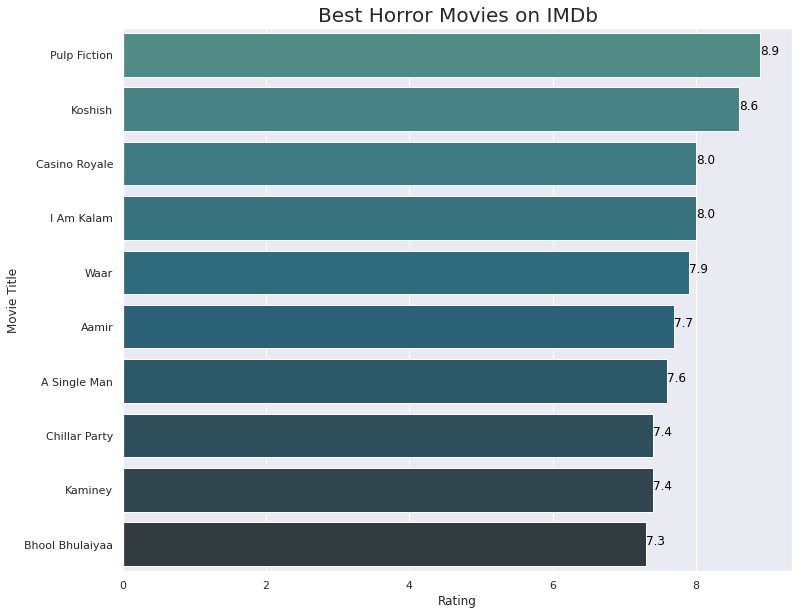

In [ ]:
Top_Genre('Horror Movies',10)

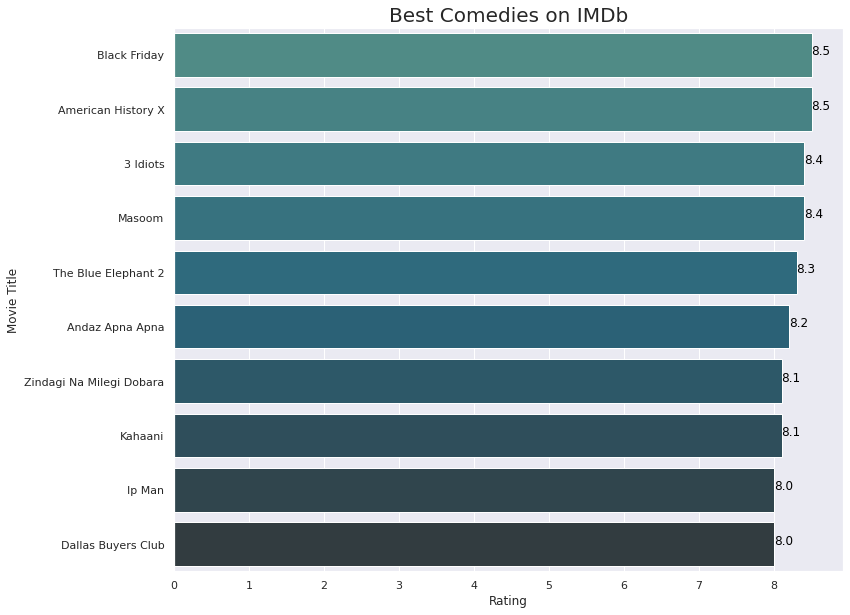

In [ ]:
Top_Genre('Comedies',10)

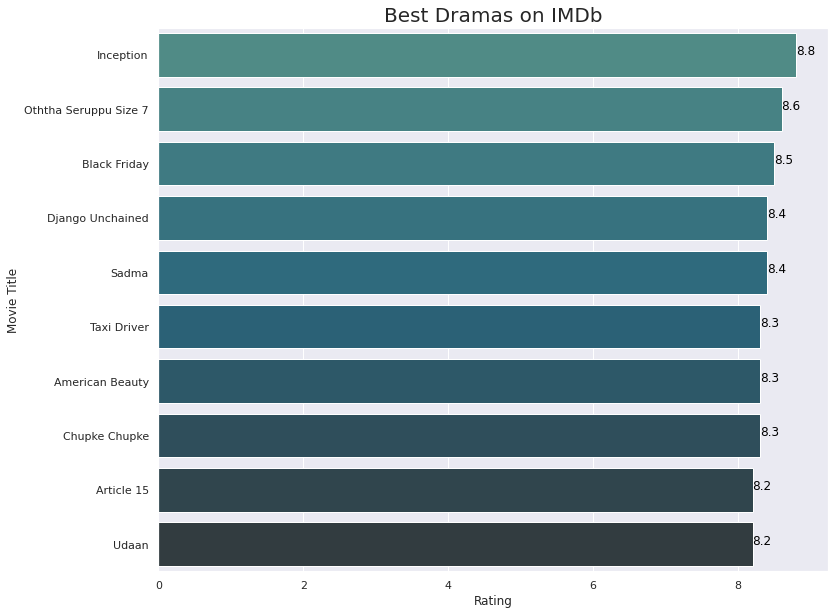

In [ ]:
Top_Genre('Dramas',10)

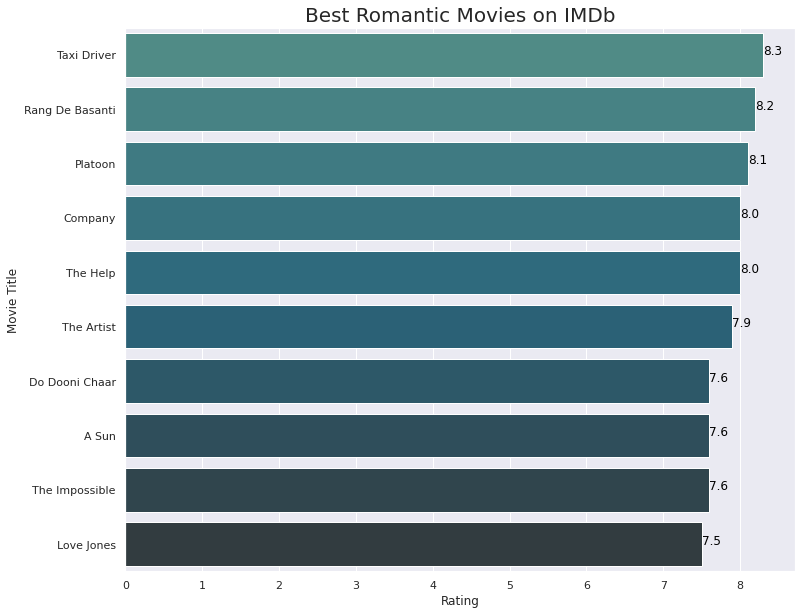

In [ ]:
Top_Genre('Romantic Movies',10)

Distribution of Different Genre by Rating

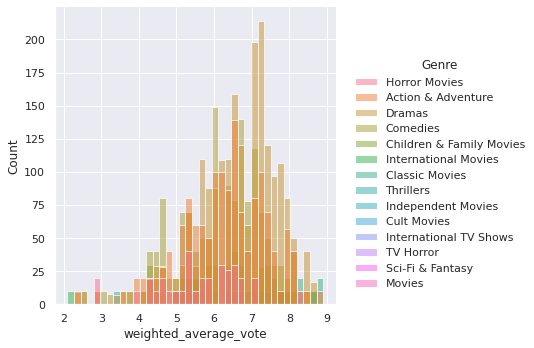

In [ ]:
genre = []
for i in range(ntf_IMDb.shape[0]):
  genre.append(re.split(r', \s*', ntf_IMDb['listed_in'][i])[0])
ntf_IMDb['Genre'] = genre
sns.displot(ntf_IMDb, x="weighted_average_vote", hue="Genre")

Rating by Countries

In [ ]:
ntf_IMDb_country = ntf_IMDb.iloc[ntf_IMDb['country'].dropna().index,:]
ntf_IMDb_country = ntf_IMDb_country.reset_index(drop=True)

Country = []
for i in range(ntf_IMDb_country.shape[0]):
  Country.append(re.split(r', \s*', ntf_IMDb_country['country'][i])[0])

ntf_IMDb_country['Country'] = Country
ntf_IMDb_country.head()

,show_id,type,title,director,cast,country,date_added,year,rating,duration,listed_in,description,weighted_average_vote,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,weighted_allgenders_0age,weighted_allgenders_18age,weighted_allgenders_30age,weighted_allgenders_45age,weighted_males_allages,weighted_males_0age,weighted_males_18age,weighted_males_30age,weighted_males_45age,weighted_females_allages,weighted_females_0age,weighted_females_18age,weighted_females_30age,weighted_females_45age,Genre,Country
0,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035,Horror Movies,Singapore
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035,Horror Movies,Singapore
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035,Horror Movies,Singapore
3,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035,Horror Movies,Singapore
4,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",4.6,1.0,1.0,4.4,132.0,4.8,335.0,4.5,177.0,4.5,519.0,1.0,1.0,4.4,90.0,4.7,268.0,4.2,138.0,5.1,151.0,NaN,NaN,4.5,39.0,5.3,63.0,5.3,38.0,5.895105,5.725088,5.62397,5.689465,5.421659,5.895105,5.776147,5.646372,5.693849,5.795048,NaN,5.847449,5.86444,5.878035,Horror Movies,Singapore


There are 23 types in the Netflix Genre Dataset


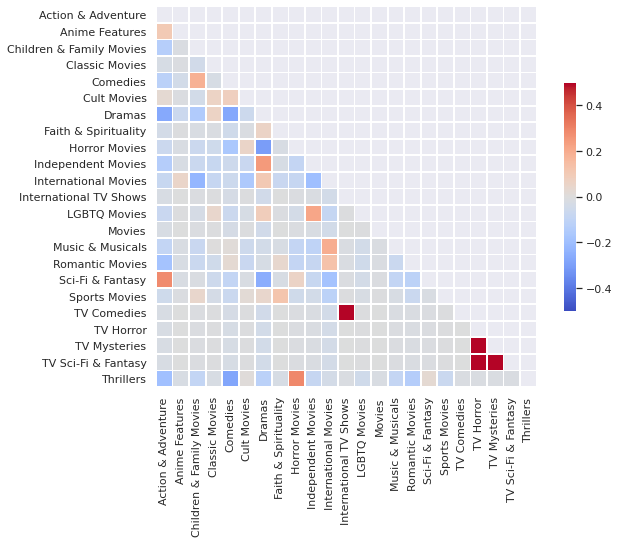

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer 

def relation_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    pl = sns.heatmap(corr, mask=mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, square=True, linewidths=.7,
                     cbar_kws={"shrink": 0.6})
    
    plt.show()
relation_heatmap(ntf_IMDb, 'Genre')

In [ ]:
rating_order_movie =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']

In [ ]:
movie_agerating = ntf_IMDb['rating'].value_counts(dropna=True)

In [ ]:
def rating_barplot(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(15, 7))
    if h_lim :
        ax.set_ylim(0, h_lim)
    ax.bar(data.index, data,  color="#d0d0d0", width=0.6, edgecolor='black')

    color =  ['green',  'blue',  'orange',  'red']
    span_range = [[0, 2], [3,  6], [7, 8], [9, 11]]

    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.1)

    ax.set_title(f'Distribution of {title} Rating', fontsize=20, fontweight='bold', position=(0.5, 1.0+0.03))
    plt.show()


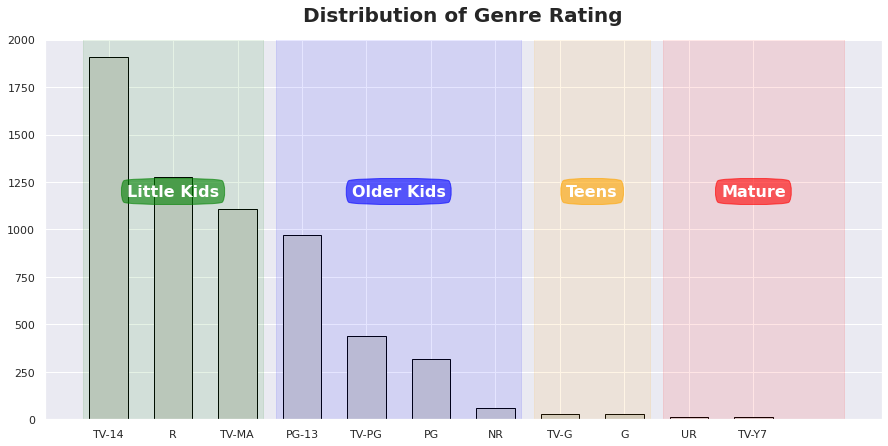

In [ ]:
rating_barplot(movie_agerating,'Genre', 1200)

In [ ]:
ntf_IMDb_country = ntf_IMDb_country.loc[:,['type','Country','weighted_average_vote','year']]
ntf_IMDb_country['Country'].value_counts()
ntf_IMDb_India = ntf_IMDb_country[ntf_IMDb_country.Country=='India']
India_rating = ntf_IMDb_India.groupby('year')['weighted_average_vote'].mean()

Text(0, 0.5, 'Average Rating')

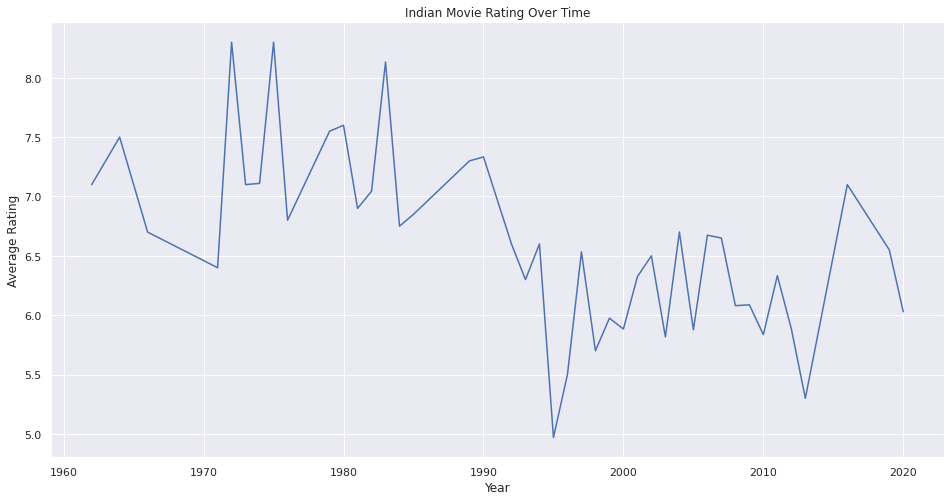

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(India_rating.index, India_rating)
plt.title('Indian Movie Rating Over Time')
plt.xlabel("Year")
plt.ylabel("Average Rating")
# plt.figure(figsize=(16, 8))
# sns.lineplot(data=India_rating, x=India_rating.index, y=India_rating)
# plt.title('Indian Movie Rating Over Time')
# plt.xlabel("Year")
# plt.ylabel("Average Rating")

Text(0, 0.5, 'Average Rating')

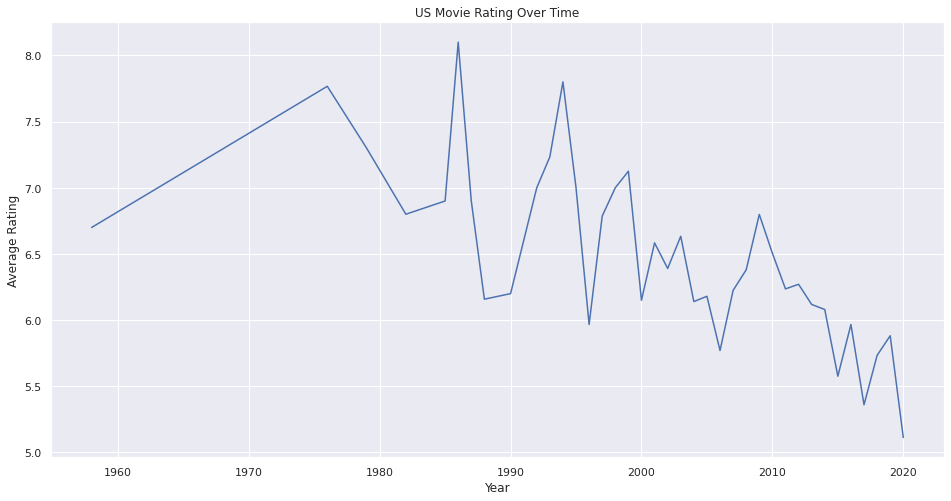

In [ ]:
ntf_IMDb_US = ntf_IMDb_country[ntf_IMDb_country.Country=='United States']
US_rating = ntf_IMDb_US.groupby('year')['weighted_average_vote'].mean()
plt.figure(figsize=(16, 8))
sns.lineplot(data=US_rating, x=US_rating.index, y=US_rating)
plt.title('US Movie Rating Over Time')
plt.xlabel("Year")
plt.ylabel("Average Rating")

Text(0, 0.5, 'Average Rating')

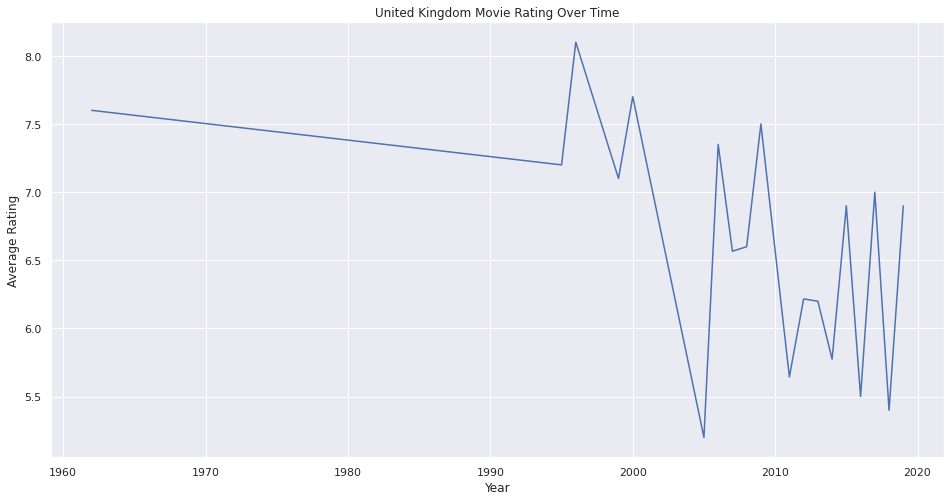

In [ ]:
ntf_IMDb_UK = ntf_IMDb_country[ntf_IMDb_country.Country=='United Kingdom']
UK_rating = ntf_IMDb_UK.groupby('year')['weighted_average_vote'].mean()
plt.figure(figsize=(16, 8))
sns.lineplot(data=UK_rating, x=UK_rating.index, y=UK_rating)
plt.title('United Kingdom Movie Rating Over Time')
plt.xlabel("Year")
plt.ylabel("Average Rating")

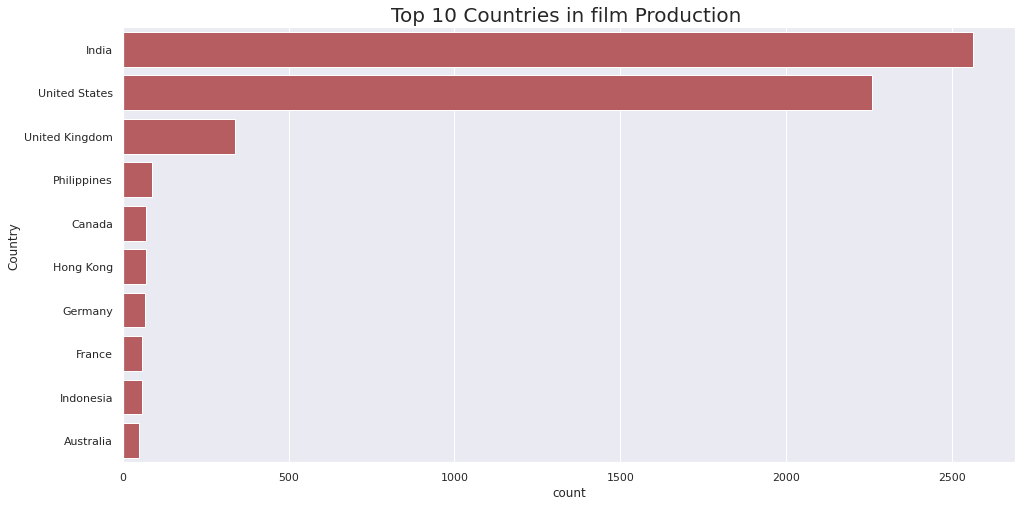

In [ ]:
base_color = sns.color_palette()[3]
plt.figure(figsize=(16, 8))
sns.countplot(y = 'Country',color= base_color, data = ntf_IMDb_country, order = ntf_IMDb_country.Country.value_counts().head(10).index)
plt.title("Top 10 Countries in film Production ", fontsize = 20);

In [ ]:
# ntf_IMDb[ntf_IMDb["type"] == "Movie"].groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
# # ntf_IMDb[ntf_IMDb["type"] == "Movie"].groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
# bar_country_movie = ntf_IMDb_country[ntf_IMDb_country["type"] == "Movie"].groupby('Country').count().sort_values('type',ascending=False).head(10)
# bar_country_tv = ntf_IMDb_country[ntf_IMDb_country["type"] == "TV Show"].groupby('Country').count().sort_values('type',ascending=False).head(10)

# plt.figure(figsize=(16, 8))
# plt.fontsize = 20
# plt.xticks(rotation=75)
# plt.title(label='Number of Titles Available by Country (Movies in Blue)')
# plt.xlabel("Country")
# plt.ylabel("Number of Titles")
# sns.barplot(bar_country_movie.index, bar_country_movie['type'], color="Blue");
# sns.barplot(bar_country_tv.index, bar_country_tv['type'], color="Red");
# plt.legend({"Movies":"Blue", "TV Shows": "Red"});

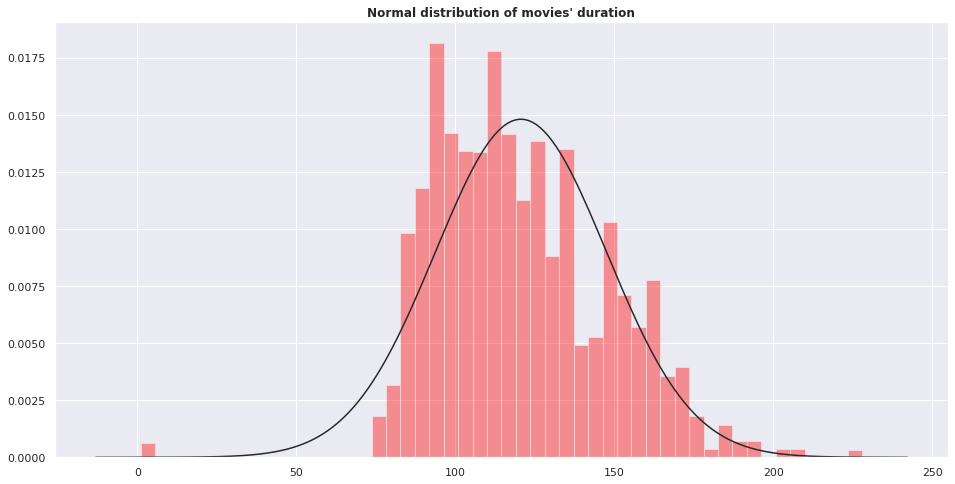

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(ntf_IMDb['duration'].str.extract('(\d+)'), fit=norm, kde=False, color=['red'])
plt.title("Normal distribution of movies' duration", fontweight="bold")
plt.show()

News and TV Shows on Netflix

In [ ]:
ntf_movie = ntf[ntf['type']=='Movie']
ntf_tv = ntf[ntf['type']=='TV Show']

In [ ]:
ntf2 = ntf.loc[:,['year','type']]
ntf_year_type = ntf2.groupby(['year','type']).size().reset_index(name='counts')
ntf_year_type = ntf_year_type.sort_values(by='year',ascending=False).reset_index()
ntf_year_type = ntf_year_type.drop(columns=['index'])
print(ntf_year_type)

     year     type  counts
0    2021  TV Show      19
1    2021    Movie      12
2    2020  TV Show     457
3    2020    Movie     411
4    2019  TV Show     414
..    ...      ...     ...
113  1945    Movie       3
114  1944    Movie       3
115  1943    Movie       3
116  1942    Movie       2
117  1925  TV Show       1

[118 rows x 3 columns]


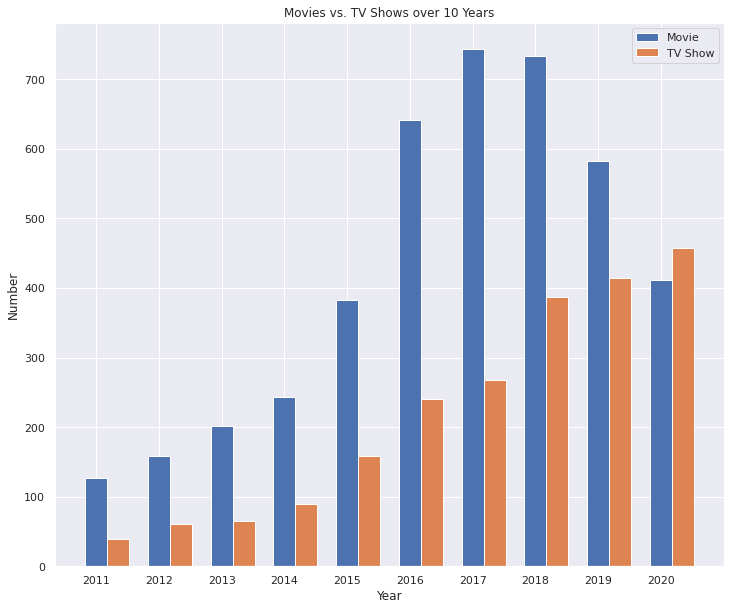

In [ ]:
x_year = np.sort(ntf['year'].value_counts().index)[-11:-1]
y_movie = ntf_movie.groupby('year').size()[-11:-1]
y_tv = ntf_tv.groupby('year').size()[-11:-1]
x1 = np.arange(len(x_year))

fig, ax = plt.subplots()
ax.bar(x1, y_movie, width=0.35, label='Movie')
ax.bar(x1+0.35, y_tv, width=0.35, label='TV Show')

ax.set_ylabel('Number')
ax.set_xlabel('Year')
ax.set_title('Movies vs. TV Shows over 10 Years')
ax.set_xticks(x1)
ax.set_xticklabels(x_year)
ax.legend()

plt.show()

In [ ]:
ntf_country = ntf.iloc[ntf['country'].dropna().index,:]
ntf_country = ntf_country.reset_index(drop=True)

Country = []
for i in range(ntf_country.shape[0]):
  Country.append(re.split(r', \s*', ntf_country['country'][i])[0])

ntf_country['Country'] = Country
ntf_country.head()

,show_id,type,title,director,cast,country,date_added,year,rating,duration,listed_in,description,Country
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,Brazil
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,Mexico
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",Singapore
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",United States
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,United States


In [ ]:
x_country = ntf_country['Country'].value_counts()[:10].index
ntf_country_movie = ntf_country[ntf_country['type']=='Movie']
ntf_country_tv = ntf_country[ntf_country['type']=='TV Show']
y_country_movie = ntf_country_movie.groupby('Country').size()[:10]
y_country_tv = ntf_country_tv.groupby('Country').size()[:10]

In [ ]:
y_country_movie = [None]*len(x_country)
for i in range(len(x_country)):
  y_country_movie[i] = ntf_country_movie[ntf_country_movie['Country'] == x_country[i]].shape[0]
y_country_tv = [None]*len(x_country)
for i in range(len(x_country)):
  y_country_tv[i] = ntf_country_tv[ntf_country_tv['Country'] == x_country[i]].shape[0]

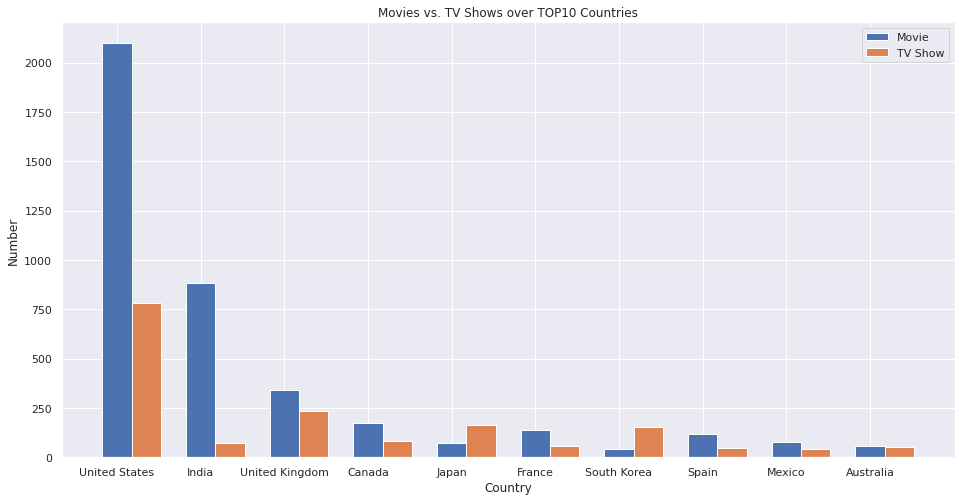

In [ ]:
x2 = np.arange(len(x_country))
plt.figure(figsize=(16, 8))
plt.bar(x2, list(y_country_movie), width=0.35,label='Movie')
plt.bar(x2+0.35, list(y_country_tv), width=0.35, label='TV Show')
plt.xticks(x2, x_country)
plt.xlabel("Country")
plt.ylabel("Number")
plt.title('Movies vs. TV Shows over TOP10 Countries')
plt.legend()
plt.show()

Topic Modeling & Cosine Similarity

In [ ]:
## I will include information of type, title, director, cast, country, listed in, description into recomendation engine
col = ['title', 'type', 'listed_in', 'director', 'cast', 'rating', 'description']
ntf['all_info'] = ntf[col].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
ntf['all_info'] = ntf['all_info'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [ ]:
## creating document term matrix
all_info = ntf['all_info']
count_vectorizer = CountVectorizer(stop_words='english') # convert all words to lowercase and remove stop words
sparse_matrix = count_vectorizer.fit_transform(all_info)
doc_term_matrix = sparse_matrix.todense()
matrix_ntf = pd.DataFrame(doc_term_matrix, columns=count_vectorizer.get_feature_names(), index=ntf.index)

In [ ]:
similarity_scores = cosine_similarity(sparse_matrix, sparse_matrix) 
scores = pd.DataFrame(similarity_scores )

In [ ]:
def recommend(title):
    recommended = []
    title = title.lower()
    ntf['title'] = ntf['title'].str.lower()
    index = ntf[ntf['title']==title].index[0]
    top10_list = list(scores.iloc[index].sort_values(ascending = False).iloc[1:11].index)
    for each in top10_list:
        recommended.append(ntf.iloc[each].title) 
    return recommended
    

In [ ]:
recommend('Avengers: Infinity War')

['thor: ragnarok',
 "cirque du freak: the vampire's assistant",
 'inception',
 'the cloverfield paradox',
 'chris brown: welcome to my life',
 'hulk vs.',
 'takers',
 'her',
 'star wars: episode viii: the last jedi',
 'scorpion king 5: book of souls']

LDA

In [ ]:
## include information of title, director, cast, country, description into recomendation engine
col = ['title', 'director', 'cast', 'rating', 'description']
ntf['all_info2'] = ntf[col].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
ntf['all_info2'] = ntf['all_info2'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [ ]:
def sentence(sentences):
    for item in sentences:
        yield(gensim.utils.simple_preprocess(str(item), deacc=True)) 

sentence_words = list(sentence(ntf['all_info2']))

In [ ]:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
words_removestop= remove_stopwords(sentence_words)

In [ ]:
# Build the bigram 
bigram = gensim.models.Phrases(sentence_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram = gensim.models.phrases.Phraser(bigram)
def bigrams(input):
    return [bigram[doc] for doc in input]
word_bigrams = bigrams(words_removestop)

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatization = lemmatization(word_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

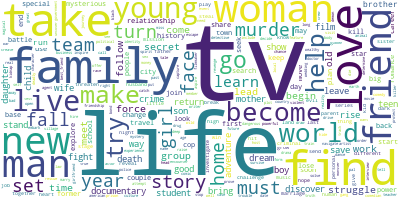

In [ ]:
## wordcloud
words = list(itertools.chain.from_iterable(data_lemmatization))
long_string = ','.join(word for word in words)

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)
wordcloud.generate(long_string)
wordcloud.to_image()


In [ ]:
dic = corpora.Dictionary(data_lemmatization) # Create Dictionary
dic.filter_extremes(no_below=2, no_above=0.9) # Filtering too little document(1) and too common document(more than 90%) 
corpus = [dic.doc2bow(i) for i in data_lemmatization] ## Term Document Frequency

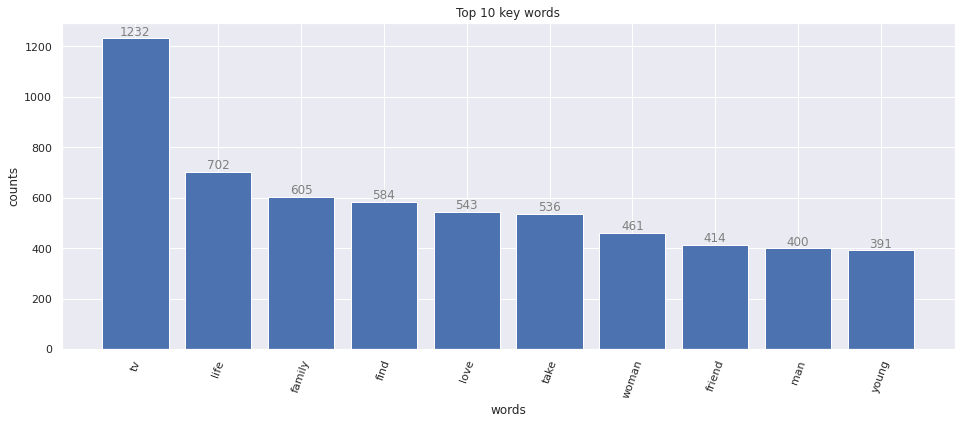

In [ ]:
# word_freq = []
# word_list = []
## visualized key words
count_dic = {}
for i in dic.values():
    count_dic[i] = words.count(i)
sorted_dic = sorted(count_dic.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dic)), [val[1] for val in sorted_dic], align='center')
plt.xticks(range(len(sorted_dic)), [val[0] for val in sorted_dic])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')
plt.title('Top 10 key words')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()

In [ ]:
def coherence(k):
  lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dic,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
  coherence = CoherenceModel(model=lda_model, texts=data_lemmatization, dictionary=dic, coherence='c_v')
  coherence_lda = coherence.get_coherence()
  return coherence_lda

In [ ]:
# find best number of topic, iterate over 1 to 30
topic_num = range(1, 40)
coherence_score = []
for num in topic_num:
    coherence_score.append(coherence(num))

In [ ]:
coherence_frame = pd.DataFrame()
coherence_frame["topic number"] = topic_num
coherence_frame['coherence score'] = coherence_score
coherence_frame

,topic number,coherence score
0,1,0.100887
1,2,0.112176
2,3,0.144395
3,4,0.178800
4,5,0.214759
5,6,0.247730
6,7,0.245831
7,8,0.256607
8,9,0.270346
9,10,0.273125


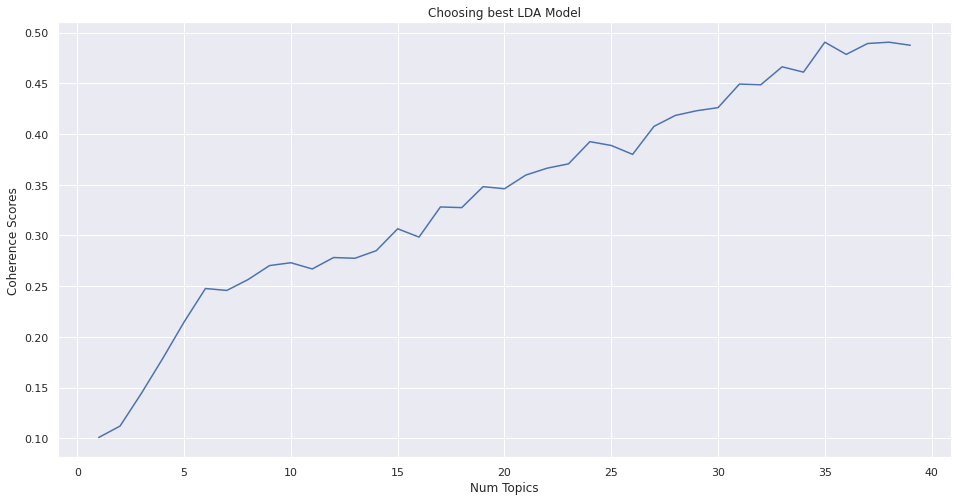

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(topic_num, coherence_frame['coherence score'])

plt.title("Choosing best LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dic,
                                       num_topics=37, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
!pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis.gensim
# import pickle 
# import pyLDAvis
# pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dic, sort_topics=False)
LDAvis_prepared

     |████████████████████████████████| 1.7MB 3.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 269kB/s 
     |████████████████████████████████| 9.9MB 40.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=5a7fa654a2b265b3195f32f803a67434c57a355a0fbe54c6ab937318c43076fa
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.084819  0.035618       1        1  2.897954
1      0.097317 -0.095079       2        1  2.533824
2     -0.153447 -0.140253       3        1  2.981561
3     -0.186653  0.095678       4        1  3.440009
4      0.106169 -0.016812       5        1  2.468174
5     -0.004182 -0.015770       6        1  2.238892
6      0.026648  0.036583       7        1  2.957377
7      0.011757  0.152824       8        1  2.794585
8      0.057403 -0.075180       9        1  2.420053
9     -0.019444  0.027097      10        1  2.399727
10    -0.077087 -0.078335      11        1  2.369376
11    -0.008802 -0.005898      12        1  2.970341
12     0.119475 -0.112447      13        1  2.520681
13     0.020052  0.125111      14        1  2.736441
14     0.113557  0.048883      15        1  2.256510
15    -0.043201 -0.162976      16        1  2.609825
16     0.117035

In [ ]:
m1 = pyLDAvis.save_html(LDAvis_prepared,'lda.html')